In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [77]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [78]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [79]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


In [80]:
trans_full['country'].unique()

array(['NL', nan, 'IT', 'AT', 'DE', 'ES', 'LV', 'CH', 'SE', 'GB', 'FR',
       'DK', 'PL', 'CZ', 'NO', 'PT', 'FI', 'BE', 'IE', 'UK'], dtype=object)

# Filter Dataset:

### _ONLY BE

In [81]:

trans_be = trans_full.loc[trans_full['country'] == 'BE']
trans_be = trans_be.sort_values('Date', ascending = True)
trans_be = trans_be.drop(['country'], axis = 1)
trans_be.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
87157,2015-05-21,CC Adapter Tray Euro Dolly,51,B-Kampenhout Rotra
87156,2015-05-21,CC Euro Dolly,204,B-Kampenhout Rotra
84941,2015-05-26,CC Adapter Tray Euro Dolly,45,B-Kampenhout Rotra
76854,2015-05-26,CC Adapter Tray Euro Dolly,1,B-Kampenhout Rotra
86768,2015-05-26,CC Euro Dolly,252,B-Kampenhout Rotra


In [164]:
trans_be['name'].unique()

array(['B-Lokeren MSI'], dtype=object)

### _RTI = Container Base

In [1]:
be_cb = trans_be.loc[trans_be['T_RTI_NAME'] == 'CC Container Base']
be_cb = be_cb.drop(['T_RTI_NAME'], axis = 1)
be_cb['Date'] = pd.to_datetime(be_cb['Date'])
be_cb = be_cb.set_index('Date')
#be_cb

NameError: name 'trans_be' is not defined

In [163]:
be_cb['name'].unique()

array(['B-Lokeren MSI'], dtype=object)

Text(0.5, 1.0, 'CB_BE Jul 2014--Jul 2019')

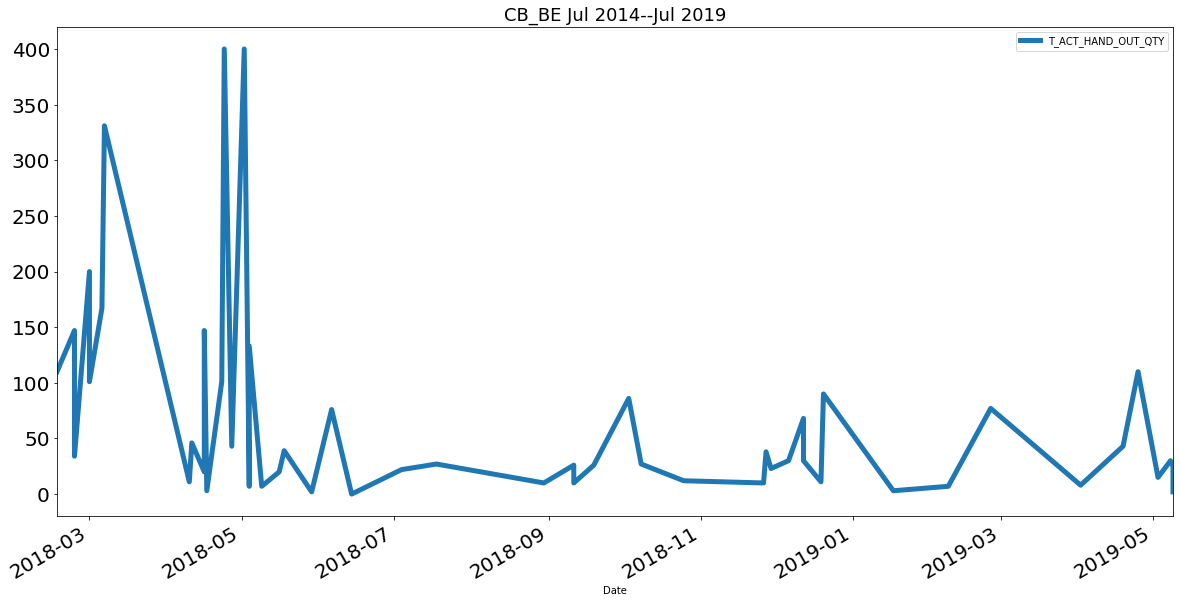

In [83]:
be_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_BE Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2016 on

Text(0.5, 1.0, 'CB_BE : Jan 2016--Jul 2019')

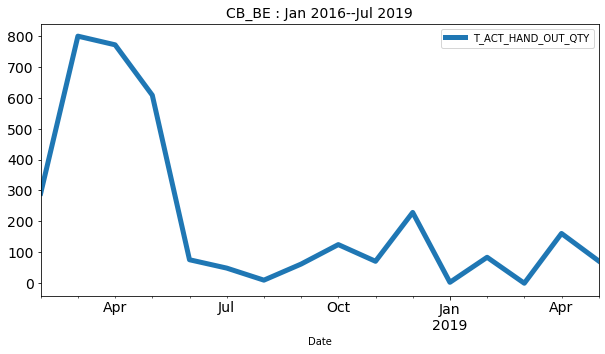

In [84]:
import datetime
be_cbm = be_cb.resample('1M').sum()
be_cb_m = be_cbm[(be_cbm.index >= datetime.datetime(2016,1,31))]
be_cb_m.plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title("CB_BE : Jan 2016--Jul 2019", fontsize = 14)

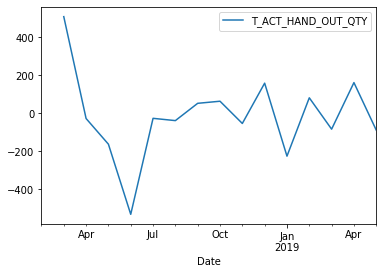

In [85]:
be_cb_mdiff = be_cb_m.diff()
be_cb_mdiff.plot()

## Seasonal Decompose 2016

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(be_cb_m)
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

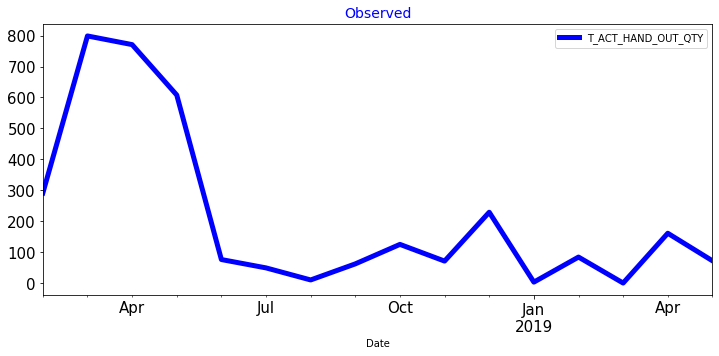

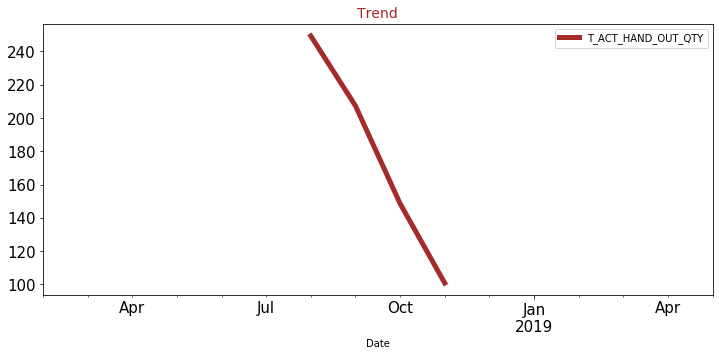

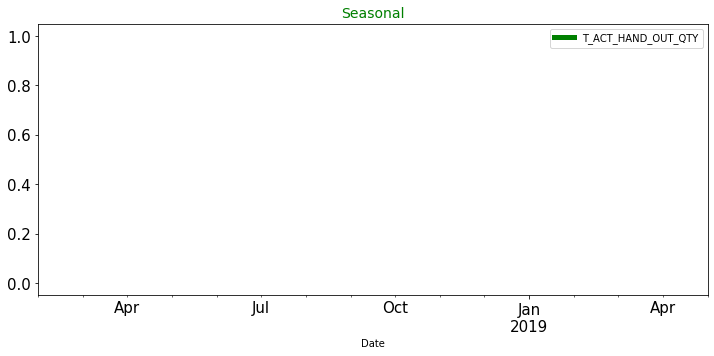

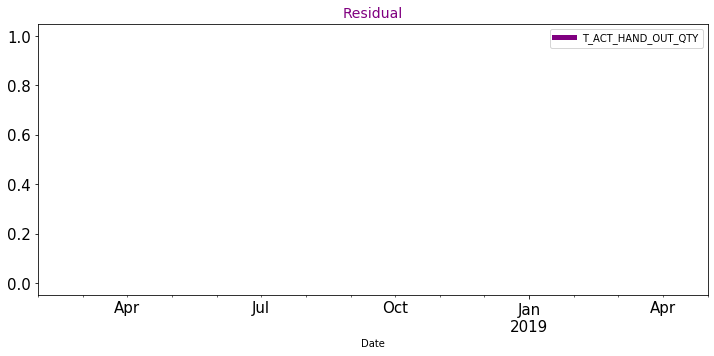

In [87]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [88]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(be_cb_m, start_p=1, start_q=1,
                           max_p=6, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=34.095, BIC=31.481, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=32.976, BIC=31.669, Fit time=0.011 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=0.031 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2

In [89]:
train = be_cb_m.loc['2016-01-31':'2018-12-31']
test = be_cb_m.loc['2019-01-31':]

In [90]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [91]:
future_forecast = stepwise_model.predict(n_periods=5)
future_forecast

array([ 387. ,  704.8, 1211. , 1181.2, 1016.4])

Text(0.5, 1.0, '2019 Prediction of BE-CB')

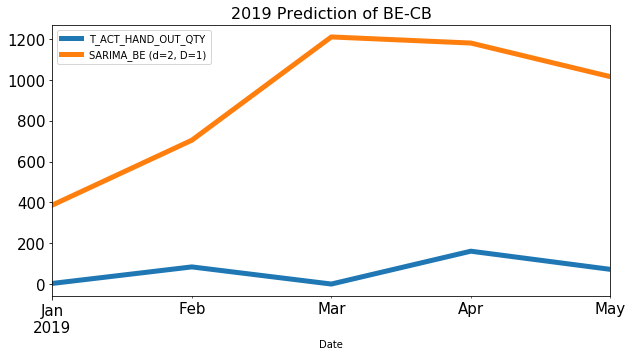

In [92]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['SARIMA_BE (d=2, D=1)'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)  
plt.title('2019 Prediction of BE-CB', fontsize = 16)

In [93]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

786413.8080000011

In [94]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

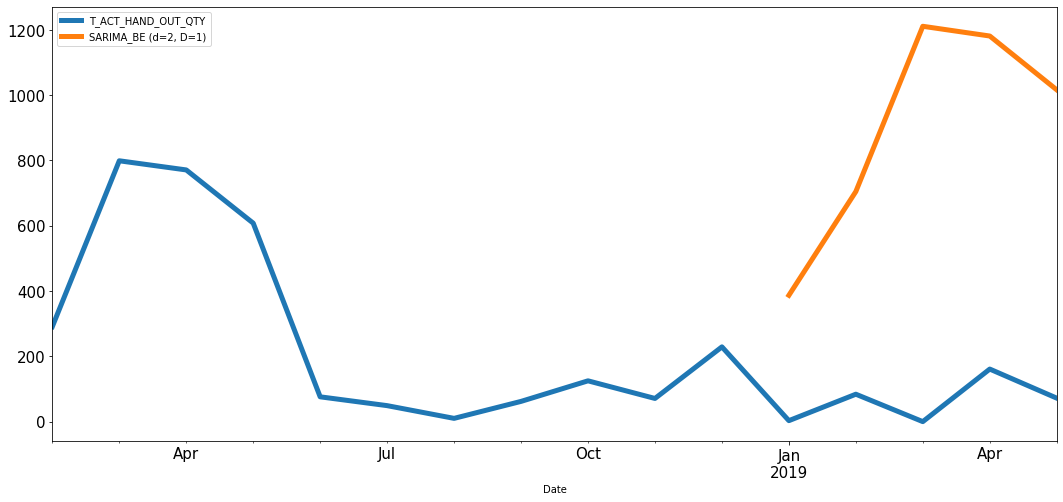

In [95]:
pd.concat([be_cb_m,future_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

In [96]:
#be_cb_m.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/Austria.xlsx')

In [97]:
future_forecast = future_forecast.where(future_forecast > 0, 0)
future_forecast

,"SARIMA_BE (d=2, D=1)"
Date,
2019-01-31,387.0
2019-02-28,704.8
2019-03-31,1211.0
2019-04-30,1181.2
2019-05-31,1016.4


In [98]:
#future_forecast.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/2diff_SARIMA_AT.xlsx')

In [99]:
#nl_cb_m.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/AT_Monthly.xlsx')

## d = 1 & D = 0

In [165]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
diffed_model = arima.auto_arima(be_cb_m, start_p=3, start_q=3,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(diffed_model.aic())

Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=207.842, BIC=209.258, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=209.838, BIC=211.963, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=209.839, BIC=211.963, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=205.911, BIC=206.619, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=211.379, BIC=214.211, Fit time=0.094 seconds
Total fit time: 0.218 seconds
205.91069852799865


In [135]:
diffed_fit = diffed_model.fit(train)

In [136]:
diffed_forecast = diffed_fit.predict(n_periods=5)
diffed_forecast

array([229., 229., 229., 229., 229.])

Text(0.5, 1.0, '2019 Prediction of BE-CB')

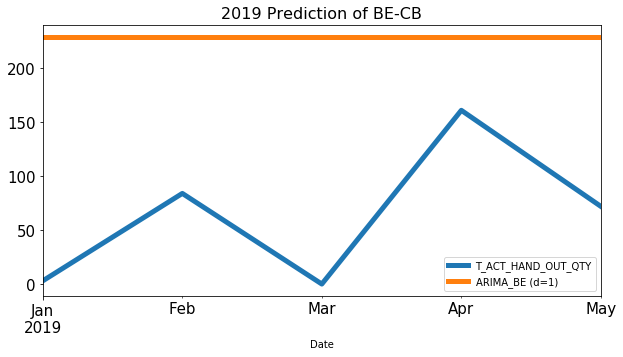

In [137]:
diffed_forecast = pd.DataFrame(diffed_forecast,index = test.index,columns=['ARIMA_BE (d=1)'])
pd.concat([test,diffed_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of BE-CB', fontsize = 16)

In [138]:
diffed_mse = mean_squared_error(test, diffed_forecast)
diffed_mse

30763.0

Text(0.5, 1.0, '2019 (One_Degree_differenced) Prediction of BE-CB')

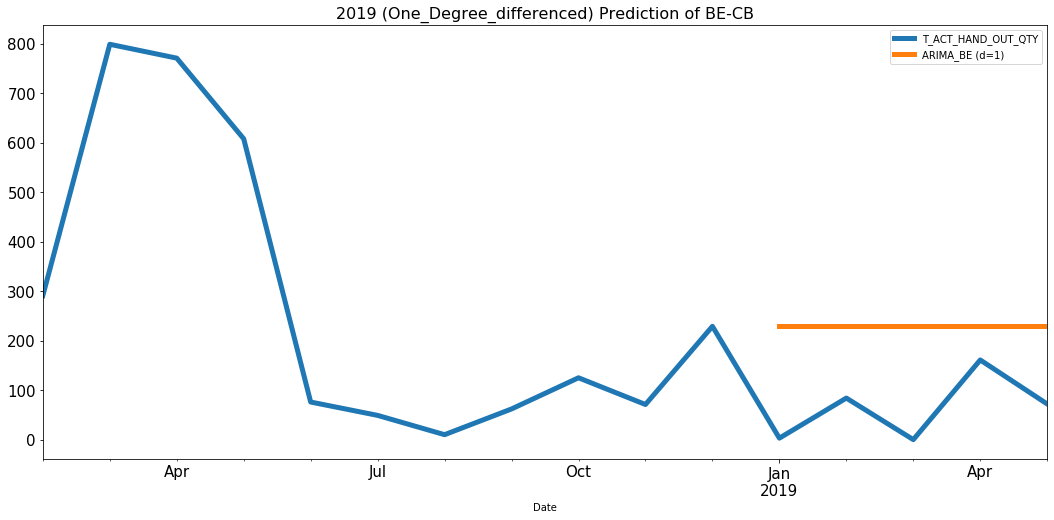

In [139]:
pd.concat([be_cb_m, diffed_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (One_Degree_differenced) Prediction of BE-CB', fontsize = 16)

## d&D = 0

In [140]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(be_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=221.988, BIC=225.078, Fit time=0.080 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=227.374, BIC=228.920, Fit time=0.124 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=220.359, BIC=222.677, Fit time=0.031 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=222.870, BIC=225.187, Fit time=0.038 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=233.591, BIC=234.364, Fit time=0.003 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=221.206, BIC=224.297, Fit time=0.067 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=221.676, BIC=225.539, Fit time=0.115 seconds
Total fit time: 0.461 seconds
220.3590743895451


In [141]:
nodiff_fit = nodiff_model.fit(train)

In [142]:
nondiff_forecast = nodiff_fit.predict(n_periods=5)
nondiff_forecast

array([247.19514092, 258.38793233, 265.27320902, 269.50870607,
       272.11418383])

Text(0.5, 1.0, '2019 Prediction of BE-CB')

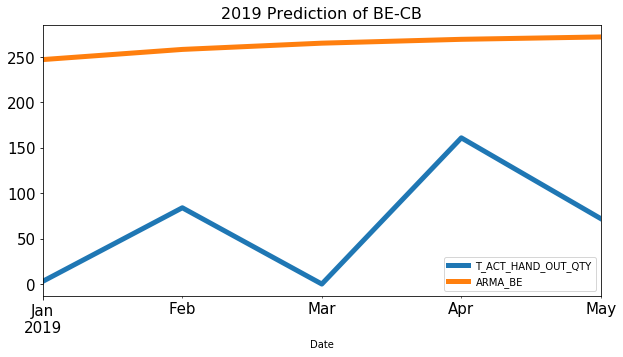

In [143]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['ARMA_BE'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of BE-CB', fontsize = 16)

In [144]:
#nondiff_forecast.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/nondiff_SARIMA_AT.xlsx')

In [145]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

42446.423815812086

Text(0.5, 1.0, '2019 (non-diff) Prediction of AT-CB')

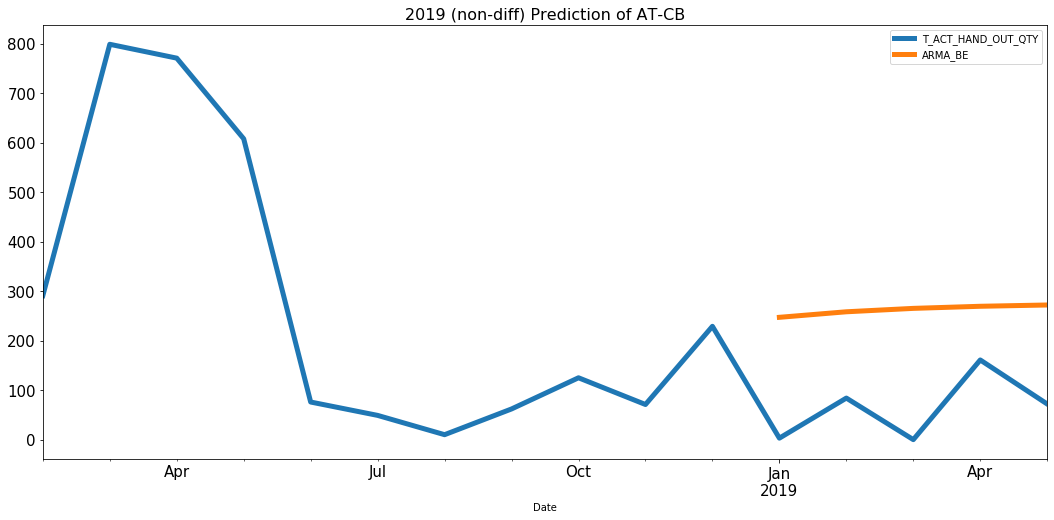

In [146]:
pd.concat([be_cb_m,nondiff_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of AT-CB', fontsize = 16)

## Comparison

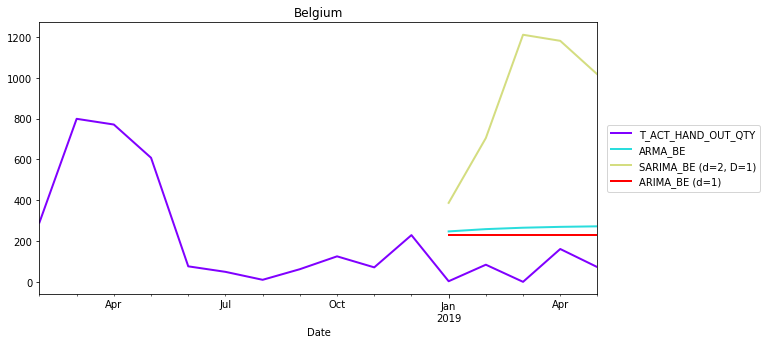

In [147]:
pd.concat([be_cb_m, nondiff_forecast, future_forecast, diffed_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Belgium')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [148]:
MSEs = [mse, nondiff_mse]

In [149]:
norm = [i/sum(MSEs) for i in MSEs]
norm

[0.9487894072046101, 0.0512105927953899]

In [150]:
MSEs.index(min(MSEs))

1

In [151]:
max(MSEs)

786413.8080000011

In [152]:
mse

786413.8080000011

In [153]:
from math import sqrt
sqrt(mse)

886.7997564275721

In [154]:
nondiff_mse

42446.423815812086

In [155]:
sqrt(nondiff_mse)

206.0252989703257

## DEPOTS

In [159]:
trans_be = be_cb
#trans_be['Date'] = pd.to_datetime(trans_be['Date'])

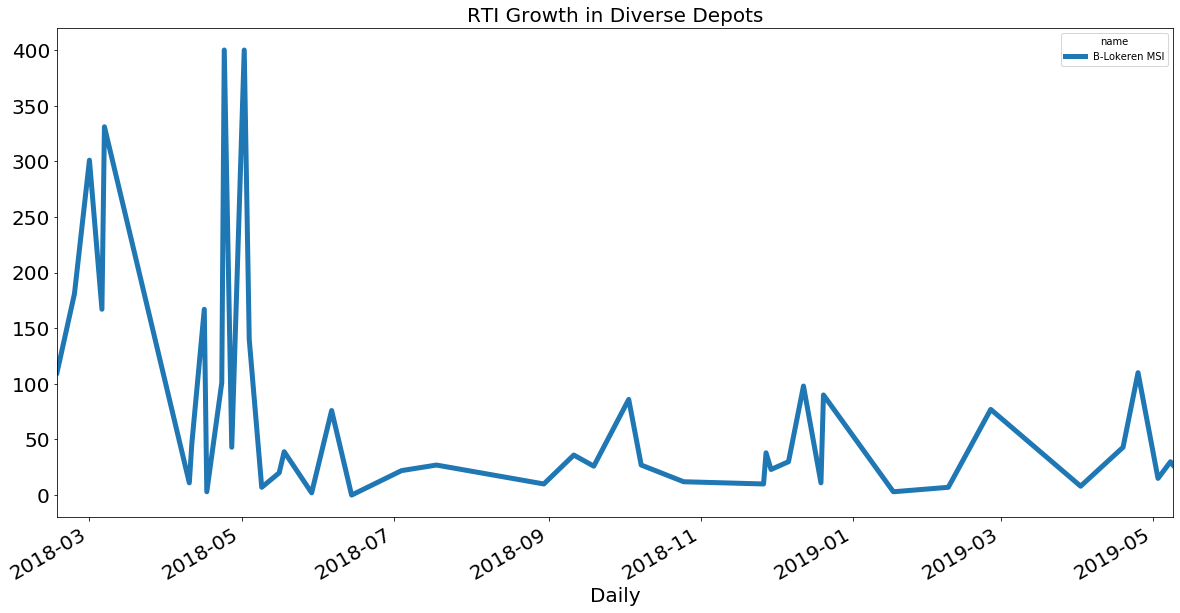

In [161]:
(trans_be.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

In [ ]:
at_deps = trans_at.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
at_deps_month = at_deps.resample('1M').sum()
at_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

## From 2017 on

In [ ]:
import datetime
at_cb2016 = at_deps_month[(at_deps_month.index >= datetime.datetime(2016,1,31))]
at_cb2016.plot(figsize=(20,10), linewidth=5, fontsize=14)
plt.title("CB_AT : Jan 2016--Jul 2019", fontsize = 18)

In [ ]:
at_cb2016.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/at_cb2016.xlsx')

In [ ]:
depos = trans_at['name'].unique()

In [ ]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [ ]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = at_cb2016[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)

In [ ]:
opt_sarima_deps[0]

In [ ]:
d1 = at_cb2016[[depos[1]]].dropna()
train1 = d1.loc['2016-01-31':'2018-12-31']
test1 = d1.loc['2019-01-31':]


In [ ]:
dep1_fit = opt_sarima_deps[1].fit(train1)

In [ ]:
dep1_forecast = dep1_fit.predict(n_periods=5)
dep1_forecast

In [ ]:
dep1_forecast = np.where(dep1_forecast<0, 0, dep1_forecast)

In [ ]:
dep1_forecast = pd.DataFrame(dep1_forecast,index = test.index,columns=[depos[1] + '_Prediction'])
pd.concat([test1,dep1_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of ' + depos[1], fontsize = 14)

In [ ]:
for j in range(0,len(depos)):
    d = at_cb2016[[depos[i]]].dropna()
    

    print(d.index)

In [ ]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = at_cb2016[[depos[f]]].dropna()
    my_train = dep.loc['2016-01-31':'2019-01-31']
    my_test = dep.loc['2019-02-28':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=4)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)
    



In [ ]:
depo_test

In [ ]:
opt_deps_forecast

In [ ]:
depots_forecasts = pd.DataFrame()

In [ ]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]
    

In [ ]:
depots_forecasts

In [ ]:
len(depo_test[0])

In [ ]:
my_test

In [ ]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

In [ ]:
#depots_forecasts.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/depots_forecasts.xlsx')

In [ ]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)        

In [ ]:
depots_forecasts[[depos[0]]]

In [ ]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [ ]:
depos_mse

In [ ]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

In [ ]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

In [ ]:
for s in range(0, len(depos)):
    pd.concat([at_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

In [ ]:
#depots_forecasts = depots_forecasts.drop('total', axis=1)

### Summation is NOT a good idea for France:

In [ ]:
depots_forecasts['Austria'] = depots_forecasts.sum(axis=1)
depots_forecasts

In [ ]:
pd.concat([nl_cb_m, depots_forecasts['Austria'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')

# OLS

In [ ]:
import statsmodels.api as sm

In [ ]:
XVar = at_cb2016.drop('A-Hörsching Schachinger', axis = 1)
YVar = at_cb2016['A-Hörsching Schachinger']
YVar.head()

In [ ]:
XVar.head()

In [ ]:
linearModel = sm.OLS(YVar, XVar).fit()

In [ ]:
print(linearModel.summary())